In [1]:
import pandas as pd
import string, csv, html

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
# DATA Input
papers_file = './data/papers_22072019.csv.xz'
works_file  = './data/works_22072019.csv.xz'

# Artigos Extraidos
df_papers = pd.read_csv(papers_file, sep='|', compression='xz')
df_papers.drop(df_papers.loc[df_papers['idioma']!='Inglês'].index, inplace=True)
df_papers.drop(['id_doc','autores_cnpq','autores','idioma','revista','natureza'], axis=1, inplace=True)
df_papers.dropna(inplace=True)
df_papers.info()

# Trabalhos Extraidos
df_works = pd.read_csv(works_file, sep='|', compression='xz')
df_works.drop(df_works.loc[df_works['idioma']!='Inglês'].index, inplace=True)
df_works.drop(['id_doc','autores_cnpq','autores','idioma','anais','natureza'], axis=1, inplace=True)
df_works.dropna(inplace=True)
df_works.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61154 entries, 1 to 106125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      61154 non-null  int64 
 1   titulo  61154 non-null  object
 2   ano     61154 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 119965 entries, 1 to 341785
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      119965 non-null  int64 
 1   titulo  119965 non-null  object
 2   ano     119965 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


In [3]:
# Concatena Dataframes
frames = [df_papers, df_works]

# Concatena Artigos e Trabalhos
df_lattes = pd.concat(frames)
df_lattes.sort_values(by=['id','ano'], ignore_index=True, inplace=True)

# Localiza dados invalidos para 'ano' / Converte 'ano' em int
df_lattes.drop(df_lattes.loc[~df_lattes['ano'].astype(str).str.isnumeric()].index, inplace=True)
df_lattes['ano'] = df_lattes['ano'].astype(int)

del [frames, df_papers, df_works]
df_lattes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181104 entries, 0 to 181118
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181104 non-null  int64 
 1   titulo  181104 non-null  object
 2   ano     181104 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.5+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8938 entries, 0 to 8937
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8938 non-null   int64 
 1   titulo  8938 non-null   object
dtypes: int64(1), object(1)
memory usage: 139.8+ KB


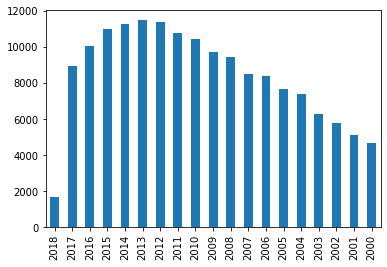

In [4]:
# Seleciona Ano
df_lattes['ano'].value_counts().sort_index(ascending=False).head(19).plot(kind='bar')

select_year = 2017

df_lattes.drop(df_lattes.loc[df_lattes['ano']!=select_year].index, inplace=True)
df_lattes.drop(['ano'], axis=1, inplace=True)
df_lattes.sort_values(by=['id'], ignore_index=True, inplace=True)
df_lattes.info()

In [5]:
# Concatena por Autor
df_lattes = df_lattes.groupby('id', sort=False).titulo.apply(' '.join).reset_index(name='titulo')
df_lattes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3055 entries, 0 to 3054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3055 non-null   int64 
 1   titulo  3055 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.9+ KB


In [6]:
# Normalização

def decode_html(text):
    decoded = html.unescape(text)
    return decoded

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def strip_ponct(text):
    words = [w.lower() for w in text if w not in string.punctuation]
    return words

df_lattes['titulo'] = df_lattes['titulo'].apply(decode_html)
df_lattes['titulo'] = df_lattes['titulo'].apply(strip_html)
df_lattes['tokens'] = df_lattes['titulo'].apply(word_tokenize)
df_lattes['tokens'] = df_lattes['tokens'].apply(strip_ponct)

In [7]:
# Remove Stopwords

sw = set(stopwords.words('english'))
sw_extra_file = open('./data/stopwords_extra.txt','r')
sw_extra = sw_extra_file.read().splitlines()

def stopwords(text):
    words = [w for w in text if not w in sw]
    return words

def stopwords_extra(text):
    words = [w for w in text if not w in sw_extra]
    return words

df_lattes['tokens'] = df_lattes['tokens'].apply(stopwords)
df_lattes['tokens'] = df_lattes['tokens'].apply(stopwords_extra)

In [8]:
# Salvar

df_lattes['titulo'] = df_lattes['tokens'].apply(lambda x: ' '.join(x))

dev_file = './data/out/dev_preprocess.csv'
ida_file = './data/out/%dauthors.csv.xz' % select_year
pre_file = './data/out/%dpreprocess.csv.xz' % select_year

df_lattes.to_csv(dev_file, index=None, columns = ['titulo'])
df_lattes.to_csv(ida_file, index=None, compression='xz', columns = ['id'])
df_lattes.to_csv(pre_file, index=None, compression='xz', columns = ['titulo'])